# Demo Notebook: Facial Attribute Estimation

#### Eunyoung Hwang, December 2020


This demo notebook is created to introduce the idea of Facial Attribute Estimation, which the processing of facial attribute extraction and predicting the results of an image. Among various algorithms of facial attribute estimation, we mainly use MXNet for facial attribute extraction which refers [this demo](https://github.com/tornadomeet/mxnet-face) and GenderNet and AgeNet for the age/gender detection which refers [this demo](https://github.com/spmallick/learnopencv/tree/master/AgeGender). As the size of the zip file is too big to be uploaded on Stud.IP, you can directly download the required data with [this link](https://www.dropbox.com/sh/cyi2semfe1i35el/AABCvRU09tZ8wKiXPxMuoYsFa?dl=0). 

## Configuration (Ulf)

In [ ]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# webcam: int
#     An integer indicating the number of the webcam to be used. If there is just
#     one webcam, this will usually be 0.
webcam = 1

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

# gpu_available: bool
#     A flag indicating if a dedicated graphical processing unit (GPU), that is
#     CUDA enabled (NVIDIA) graphic card is available. If this is the case,
#     some software packages may use specialized code that can significantly
#     (by a factor of 10-20) increase performance.
gpu_available = True

## Preparations (Ulf)

In [ ]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* OpenCv (`opencv=4.1.0`): for loading images and color space conversion
* Dlib (`dlib`): to detect faces and landmarks
* Skimage (`scikit-image`): for histogram equalization
* ImageIO (`imageio` and `imageio-ffmpeg`): for accessing the webcam
* Imutils (`imutils`): for using the face aligner by Adrian Rosebrock

In [4]:
%%writefile fae_demo_agengender.yml
name: fae_demo
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - dlib
  - opencv
  - imutils

Overwriting fae_demo_agengender.yml


## Setting up the envrionment

Running the following cell will create a file `fae_demo_agengender.yml` that can be used to setup a conda environment containing the required packages. To do so, open a shell and type
```sh
conda env create -f fae_demo_agengender.yml
```
Remember that after running this command you have to activate the environment (Linux/MacOS: `conda activate fae_demo`, Windows: `activate fae_demo`) and then start jupyter in that environment.

In [5]:
import cv2
import dlib
import imageio
import imutils
import numpy as np
import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from imutils.face_utils import shape_to_np
from imutils.face_utils import FACIAL_LANDMARKS_IDXS

## Facial Attribute Estimation with using MXNet

The MXNet algortihm is consisted of three parts: Face Detection, Face Identification, and Facial Attribute Prediction. For the Face Identification, we use a trained lightened CNN model which performs 97.13%+-0.88% with LFW. For the Facial Attribute Prediction, we use a trained lightened MOON model which gets about 87.41% accuaracy with CelebA. For the Face Attribute Prediction, the script will train the model use the original image set of CelebA, we should first do detect faces by using OpenCV and Dlib.

In [19]:
#Load path
faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

#Load face detection model
faceNet=cv2.dnn.readNet(faceModel,faceProto)
#Load age detection model
ageNet=cv2.dnn.readNet(ageModel,ageProto)
#Load gender detection model
genderNet=cv2.dnn.readNet(genderModel,genderProto)

Define color conversion fuctions beforehand which are. The codes are taken from the ones of Johanna Linkemeyer. 

In [20]:
HSV_HE = False
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def bgr_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
def hsv_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
def gray_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
def rgb_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
def rgb_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def rgb_to_bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

### Face Detection Function

In [21]:
#Detects face and extracts the coordinates
def getFaceBox(net, image, conf_threshold=0.7):
    image=image.copy()
    imageHeight=image.shape[0]
    imageWidth=image.shape[1]
    blob=cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*imageWidth)
            y1=int(detections[0,0,i,4]*imageHeight)
            x2=int(detections[0,0,i,5]*imageWidth)
            y2=int(detections[0,0,i,6]*imageHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), int(round(imageHeight/150)), 8)
    return image, faceBoxes

### Age and Gender Detection Fuction

In [22]:
def genderAge(image,faceBox):

    MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
    ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    genderList=['Male','Female']
    
    # Padding the image
    padding=20
    face=image[max(0,faceBox[1]-padding):
        min(faceBox[3]+padding,image.shape[0]-1),max(0,faceBox[0]-padding)
        :min(faceBox[2]+padding, image.shape[1]-1)]
    blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)

    # Predict the gender
    genderNet.setInput(blob)
    genderPreds=genderNet.forward()
    gender=genderList[genderPreds[0].argmax()]
    # Predict the age
    ageNet.setInput(blob)
    agePreds=ageNet.forward()
    age=ageList[agePreds[0].argmax()]

    return gender,age

### Main Function

I have excluded the Facial Attribute Prediction part as an error keeps occuring unexpectedly. So, you can detect the age and gender of an image with this fuction. I will upload the version with the part once I solve the problem. 

In [29]:
def main():
    resultImg, faceBoxes = getFaceBox(faceNet, image)
    if not faceBoxes:
        print("No face detected")
        
    for faceBox in faceBoxes:  
        # Plotting the original image
        plt.imshow(bgr_to_rgb(resultImg)) 
        plt.axis('off')
        plt.show()
        # Print detected gender and age of the image
        gender, age = genderAge(image, faceBox)
        print('gender', gender)
        print('age', age)
        

So, to get the result you can load an image and run the main function. I uploaded several images in the folder 'images'. If you want to use your own images, please edit the path as image = cv2.imread("PATH OF IMAGE").  

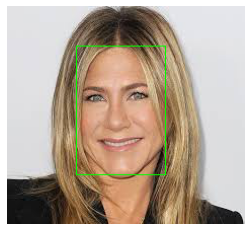

gender Female
age (25-32)


In [30]:
image = cv2.imread("images/image1.jpg")
main()